## units only ftrs : camera remote/local (eg. away/home) ratio & same but in last minutes

### 공통

In [1]:
import pickle, datetime
import pandas as pd
import numpy as np
pd.options.display.max_rows=1000
pd.options.display.max_colwidth = -1

from collections import Counter

from matplotlib import pyplot as plt

In [2]:
# 정규식
import re
cmp = re.compile('(?:Target:\s([A-Za-z]*)\s\[([0-9A-Z]*)\][\s;]*)?Location:\s\(([0-9]*)[.0-9]*,\s([0-9]*)[.0-9]*.*?\)')
coors = re.compile('(?:Location:|at)\s\(([0-9]*)[.0-9]*,\s([0-9]*)[.0-9]*.*?\)')
units = re.compile('([0-9A-Za-z]*)\s\[([0-9A-Z]*)\]')

### 학습용

In [3]:
_df = pd.read_csv('./data/train.csv', nrows=4000000)

In [ ]:
for idx in range(3): #56):
    t1 = datetime.datetime.now()
    df = _df[(_df['game_id'] < (idx*1000)+1000) & (_df['game_id'] >= (idx*1000))]

    df = df[df['event'].isin(['Camera', 'Right Click'])]

    arr_coors = df['event_contents'].map(coors.findall).map(lambda x: x[0]).apply(pd.Series)
    arr_coors.columns = ['x', 'y']
    arr_coors['x'] = arr_coors['x'].astype('int')
    arr_coors['y'] = arr_coors['y'].astype('int')
    df = pd.concat([df, arr_coors], axis=1)
    #print(f'{(datetime.datetime.now() - t1).seconds:.1f} secs')

    df.loc[:, 'slice'] = (df['time'] // 1).astype(int)

    center_p0 = df[df['player'] == 0].groupby(by=['game_id']).first()[['x', 'y']]
    center_p1 = df[df['player'] == 1].groupby(by=['game_id']).first()[['x', 'y']]
    df = pd.merge(df, center_p0, left_on=['game_id'], right_index=True, suffixes=['', '_center_p0'])
    df = pd.merge(df, center_p1, left_on=['game_id'], right_index=True, suffixes=['', '_center_p1'])
    df['dist_from_p0'] = np.sqrt((df['x'] - df['x_center_p0']) ** 2 + (df['y'] - df['y_center_p0']) ** 2)
    df['dist_from_p1'] = np.sqrt((df['x'] - df['x_center_p1']) ** 2 + (df['y'] - df['y_center_p1']) ** 2)
    df.loc[df['player'] == 0, 'aggresive'] = df['dist_from_p0'] > df['dist_from_p1']
    df.loc[df['player'] == 1, 'aggresive'] = df['dist_from_p1'] > df['dist_from_p0'] 

    # 전체 카메라 횟수 대 remote(aggresive)의 비율
    camera_remote_cnt = df[df['aggresive']].groupby(by=['game_id', 'player']).apply(len).unstack('player').fillna(0.0)
    camera_total_cnt = df.groupby(by=['game_id', 'player']).apply(len).unstack('player').fillna(0.0)
    camera_remote_ratio_ftr = camera_remote_cnt / camera_total_cnt
    camera_remote_ratio_ftr.columns = ['cam_remote_ratio0', 'cam_remote_ratio1']

    #camera_total.columns = ['camera_p0', 'camera_p1']
    #pd.merge(camera_remote_cnt / camera_total_cnt, df.groupby(by='game_id')['winner'].first(), left_index=True, right_index=True)

    # 마지막 300개 액션만
    last_300 = df.groupby('game_id').tail(300)
    camera_remote_last_cnt = last_300[last_300['aggresive']].groupby(by=['game_id', 'player']).apply(len).unstack('player').fillna(0.0)
    camera_total_last_cnt = last_300.groupby(by=['game_id', 'player']).apply(len).unstack('player').fillna(0.0)
    camera_remote_ratio_last_ftr = camera_remote_last_cnt / camera_total_last_cnt
    camera_remote_ratio_last_ftr.columns = ['cam_remote_ratio0_last', 'cam_remote_ratio1_last']
    camera_remote_ratio_last_ftr
    #camera_total.columns = ['camera_p0', 'camera_p1']
    #pd.merge(camera_remote_cnt / camera_total_cnt, df.groupby(by='game_id')['winner'].first(), left_index=True, right_index=True)

    # 자기 영역에 침투한 비율
    camera_remote_cnt = df[df['aggresive']].groupby(by=['game_id', 'player']).apply(len).unstack('player').fillna(0.0)
    camera_local_cnt = df[~df['aggresive']].groupby(by=['game_id', 'player']).apply(len).unstack('player').fillna(0.0)
    camera_remote_cnt = camera_remote_cnt.rename(columns={0:'camera_enemy_to_p1', 1:'camera_enemy_to_p0'})
    camera_local_cnt = camera_local_cnt.rename(columns={0:'camera_home_p1', 1:'camera_home_p0'})
    camera_homeaway_ratio = pd.merge(camera_local_cnt, camera_remote_cnt, left_index=True, right_index=True)
    camera_homeaway_ratio['homeaway_p0'] = camera_homeaway_ratio['camera_enemy_to_p0'] / camera_homeaway_ratio['camera_home_p0']
    camera_homeaway_ratio['homeaway_p1'] = camera_homeaway_ratio['camera_enemy_to_p1'] / camera_homeaway_ratio['camera_home_p1']
    camera_homeaway_ratio.head()

    ret = pd.merge(camera_remote_ratio_ftr, camera_remote_ratio_last_ftr, left_index=True, right_index=True)
    ret = pd.merge(ret, camera_homeaway_ratio, left_index=True, right_index=True).fillna(0.0)
    ret = ret.reset_index(drop=False).rename(columns={'index':'game_id'})
    ret.to_csv('./data/camera_homeaway_train.csv', mode='a' if idx > 0 else 'w', index=False, header=None if idx > 0 else True)
    print(f'[{idx}] {(datetime.datetime.now() - t1).seconds:.1f} secs')

In [265]:
GID = 9
ret = []
for GID in range(25):
    df = _df[_df['game_id'] == GID]
    WINNER = df['winner'].iloc[0]

    
    center_p0 = df[df['player'] == 0].iloc[0][['x', 'y']]
    center_p1 = df[df['player'] == 1].iloc[0][['x', 'y']]
    df['dist_from_p0'] = np.sqrt((df['x'] - center_p0['x']) ** 2 + (df['y'] - center_p0['y']) ** 2)
    df['dist_from_p1'] = np.sqrt((df['x'] - center_p1['x']) ** 2 + (df['y'] - center_p1['y']) ** 2)
    df.loc[df['player'] == 0, 'aggresive'] = df['dist_from_p0'] > df['dist_from_p1']
    df.loc[df['player'] == 1, 'aggresive'] = df['dist_from_p1'] > df['dist_from_p0'] 

    df_p0 = df[df['player'] == 0]
    df_p1 = df[df['player'] == 1]

    last_3min_p0 = sorted(np.unique(df_p0['slice']))[-3]
    last_3min_p1 = sorted(np.unique(df_p1['slice']))[-3]
    metric_p0 = df_p0[(df_p0['aggresive']) & (df_p0['slice'] >= last_3min_p0)]
    metric_p1 = df_p1[(df_p1['aggresive']) & (df_p1['slice'] >= last_3min_p1)]
    
    ret.append([WINNER, len(metric_p0), len(metric_p1), df_p0.iloc[0]['species'], df_p1.iloc[0]['species']])
pd.DataFrame(ret)

/Users/a80099707/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/a80099707/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


KeyError: 'slice'

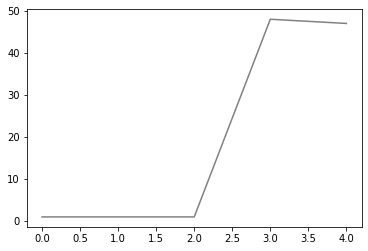

In [165]:
plt.plot(df_p0[df_p0['aggresive']].groupby(by='slice')['event'].count(), color='r' if WINNER == 0 else 'gray')
plt.plot(df_p1[df_p1['aggresive']].groupby(by='slice')['event'].count(), color='r' if WINNER == 1 else 'gray')

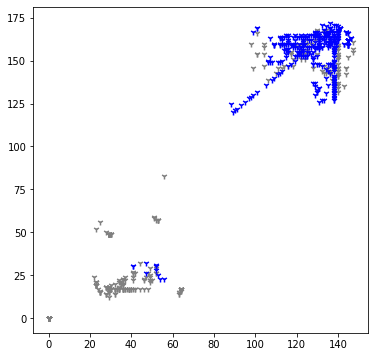

In [163]:
plt.figure(figsize=(6,6))
plt.scatter(df_p0['x'], df_p0['y'], c='r' if WINNER == 0 else 'gray', marker='1')
plt.scatter(df_p1['x'], df_p1['y'], c='b' if WINNER == 1 else 'gray', marker='1')
plt.show()

In [6]:
unit_dict = {}
abandoned_units = []
# species_units = {'Z':{}, 'P':{}, 'T':{}}
for idx, data in df.iterrows():
    if idx % 10000
    if not data['game_id'] in unit_dict:
        unit_dict[data['game_id']] = [{}, {}]
    for unit_name, unit_id in data['event_contents']:
        if unit_name and len(unit_name) > 0: # and len(npcs.findall(unit_name)) == 0:
            unit_name = re.sub('Sieged|Burrowed', '', unit_name)
            
            if unit_name in ['SCV', 'Drone', 'Probe']:
                continue
            # check the enemy has it
            if unit_id not in unit_dict[data['game_id']][(data['player'] + 1 ) % 2]:
                if unit_name in unit_set[data['species']]:
                    unit_dict[data['game_id']][data['player']][unit_id] = unit_name
                elif unit_name in whole_unit_set:
                    unit_dict[data['game_id']][(data['player'] + 1) % 2][unit_id] = unit_name
                else:
                    abandoned_units.append(unit_name)
                # save unit names per each species
#                 if unit_name in species_units[data['species']]:
#                     species_units[data['species']][unit_name] += 1
#                 else:
#                     species_units[data['species']][unit_name] = 1
        else:
            print(f"{idx}: [gid {data['game_id']}] Invalid item name {unit_name} ({unit_id})")

In [7]:
pickle.dump(unit_dict, open('./data/unit_dict.pkl', 'wb'))

In [8]:
winner_dict = df.groupby(by=['game_id'])['winner'].first().to_dict()
pickle.dump(winner_dict, open('./data/winner_dict.pkl', 'wb'))

In [9]:
unit_ftr = []
unit_cols = sorted(whole_unit_set)
game_cnt = max(df['game_id']) + 1

for g in range(game_cnt):
    unit_ftr.append([])
    for p in range(2):
        unit_ftr[-1].append({key:0 for key in unit_cols})
        for unit in unit_dict[g][p].values():
            unit_ftr[-1][p][unit] += 1

In [10]:
merged_unit_ftr = []
winner_ftr = []
for GID in range(game_cnt):
    merged_unit_ftr.append(list(unit_ftr[GID][0].values()) + list(unit_ftr[GID][1].values()))
    winner_ftr.append(winner_dict[GID])

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(merged_unit_ftr, y=winner_ftr)
pca_ftr = pca.transform(merged_unit_ftr)

In [12]:
pickle.dump(pca, open('./data/pca.pkl', 'wb'))

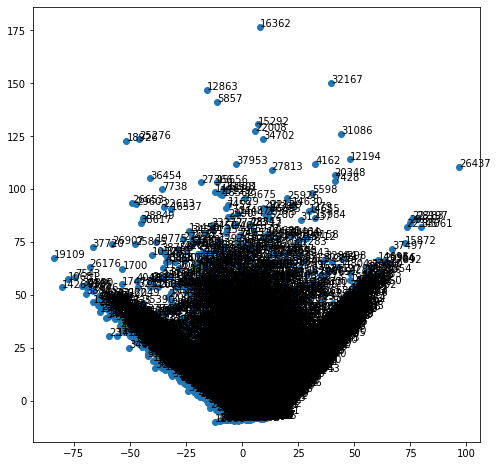

In [13]:
ys = pca_ftr[:,0]
xs = pca_ftr[:,1]

from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(xs, ys, marker='o')
for i, v in enumerate(range(game_cnt)):
    plt.annotate(v, xy=(xs[i], ys[i]))

In [14]:
ret = pd.DataFrame(pca_ftr, index=range(game_cnt))
ret.head()

,0,1,2,3,4,5,6,7,8,9
0,-7.239118,0.824455,5.636128,-0.797843,-0.469545,-0.020569,-0.830383,-0.432295,-0.064888,-0.239248
1,-7.087485,2.645308,4.767439,-8.105190,-0.759641,-0.963355,0.769272,-0.140913,0.722603,1.883549
2,2.469137,-10.379357,-3.734430,-3.142465,-0.558421,-1.389007,0.482712,-0.891283,0.167267,1.313682
3,-7.822502,-2.856204,7.435919,13.914480,-1.241673,1.620324,6.593019,2.094860,-0.999804,-3.701278
4,-4.861956,-2.785244,-1.671422,2.112014,-0.251560,-0.590533,-1.142674,-0.449859,0.155345,-0.138047


In [22]:
ret.columns = [f'unit_pca{x}' for x in ret.columns]

In [25]:
ret = ret.reset_index().rename(columns={'index':'game_id'})
ret.to_csv('./data/unit_select_pca_train.csv', index=False)

In [27]:
ret_raw = pd.DataFrame(merged_unit_ftr, index=range(game_cnt))
ret_raw.columns = unit_cols + unit_cols
ret_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [30]:
ret_raw = ret_raw.reset_index().rename(columns={'index':'game_id'})
ret_raw.to_csv('./data/unit_select_raw_train.csv', index=False)

### 예측용

In [31]:
df = pd.read_csv('./data/test.csv') #, nrows=1000000)
df.shape, df['game_id'].min(), df['game_id'].max()

((28714849, 6), 55658)

In [81]:
df.shape, df['game_id'].min(), df['game_id'].max()

((4077893, 6), 38872, 55658)

In [37]:
df = df[df['event'].isin(['Selection'])]
arr_units = df['event_contents'].map(units.findall)
del df['event_contents']
df = pd.concat([df, arr_units], axis=1)

In [52]:
unit_dict = {}
abandoned_units = []
# species_units = {'Z':{}, 'P':{}, 'T':{}}
for idx, data in df.iterrows():
    if not data['game_id'] in unit_dict:
        unit_dict[data['game_id']] = [{}, {}]
    for unit_name, unit_id in data['event_contents']:
        if unit_name and len(unit_name) > 0: # and len(npcs.findall(unit_name)) == 0:
            unit_name = re.sub('Sieged|Burrowed', '', unit_name)
            
            if unit_name in ['SCV', 'Drone', 'Probe']:
                continue
            # check the enemy has it
            if unit_id not in unit_dict[data['game_id']][(data['player'] + 1 ) % 2]:
                if unit_name in unit_set[data['species']]:
                    unit_dict[data['game_id']][data['player']][unit_id] = unit_name
                elif unit_name in whole_unit_set:
                    unit_dict[data['game_id']][(data['player'] + 1) % 2][unit_id] = unit_name
                else:
                    abandoned_units.append(unit_name)
                # save unit names per each species
#                 if unit_name in species_units[data['species']]:
#                     species_units[data['species']][unit_name] += 1
#                 else:
#                     species_units[data['species']][unit_name] = 1
        else:
            print(f"{idx}: [gid {data['game_id']}] Invalid item name {unit_name} ({unit_id})")

In [53]:
pickle.dump(unit_dict, open('./data/unit_dict_test.pkl', 'wb'))

In [54]:
game_id_idx = list(range(df['game_id'].min(), df['game_id'].max() + 1))

In [55]:
unit_ftr = []
unit_cols = sorted(whole_unit_set)
game_cnt = max(df['game_id']) + 1

for g in game_id_idx:
    unit_ftr.append([])
    for p in range(2):
        unit_ftr[-1].append({key:0 for key in unit_cols})
        for unit in unit_dict[g][p].values():
            unit_ftr[-1][p][unit] += 1

In [84]:
merged_unit_ftr = []
for idx in range(len(unit_ftr)):
    merged_unit_ftr.append(list(unit_ftr[idx][0].values()) + list(unit_ftr[idx][1].values()))

In [85]:
pca_ftr = pca.transform(merged_unit_ftr)

In [86]:

ret = pd.DataFrame(pca_ftr, index=game_id_idx)

ret.columns = [f'unit_pca{x}' for x in ret.columns]

ret = ret.reset_index().rename(columns={'index':'game_id'})
ret.to_csv('./data/unit_select_pca_test.csv', index=False)

In [88]:
ret_raw = pd.DataFrame(merged_unit_ftr, index=game_id_idx)
ret_raw.columns = unit_cols + unit_cols
ret_raw.head()

,Adept,Archon,Baneling,Banshee,Battlecruiser,BroodLord,Carrier,Colossus,Corruptor,Cyclone,...,Tempest,Thor,Ultralisk,Viking,Viper,VoidRay,WarpPrism,WidowMine,Zealot,Zergling
55654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
ret_raw = ret_raw.reset_index().rename(columns={'index':'game_id'})
ret_raw.to_csv('./data/unit_select_raw_test.csv', index=False)